# RL4CO Quickstart Notebook

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/notebooks/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/ai4co/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/ai4co/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

In this notebooks we will train the AttentionModel (AM) on the TSP environment for 20 nodes. On a GPU, this should less than 2 minutes!  🚀

![Alt text](https://user-images.githubusercontent.com/48984123/245925317-0db4efdd-1c93-4991-8f09-f3c6c1f35d60.png)

### Installation

In [8]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

### Imports

In [9]:
import torch

from rl4co.envs import TSPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

### Environment, Model and LitModule

In [10]:
# RL4CO env based on TorchRL
env = TSPEnv(num_loc=20) 

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env, 
                       baseline="rollout",
                       train_data_size=100_000,
                       val_data_size=10_000
                       ) 

/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Test greedy rollout with untrained model and plot

Problem 1 | Cost: 8.388
Problem 2 | Cost: 6.837
Problem 3 | Cost: 11.602


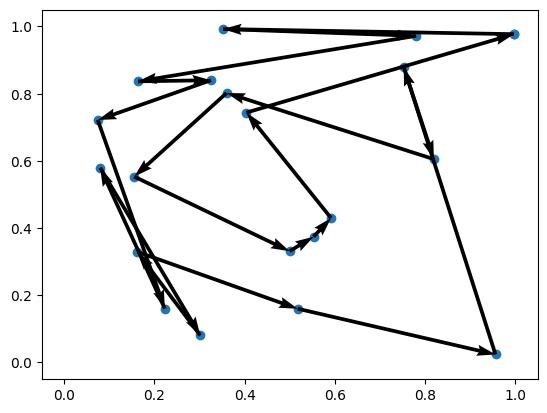

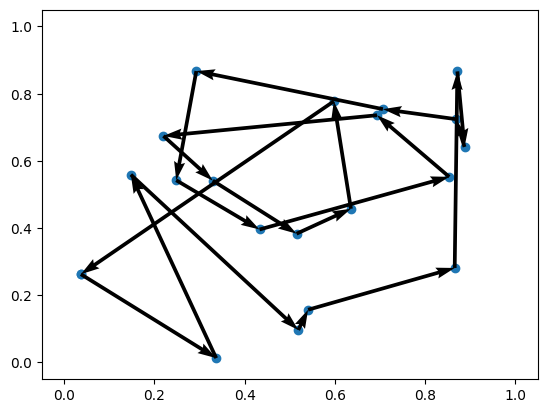

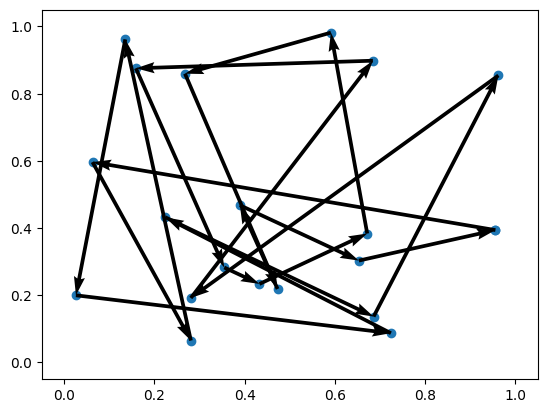

In [11]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

### Trainer

The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults

In [12]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Fit the model

In [13]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | TSPEnv               | 0     
1 | policy   | AttentionModelPolicy | 710 K 
2 | baseline | WarmupBaseline       | 710 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 38.81it/s, v_num=8, train/reward=-4.01, train/loss=-.206, val/reward=-3.98]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s, v_num=8, train/reward=-4.01, train/loss=-.206, val/reward=-3.98]


### Testing

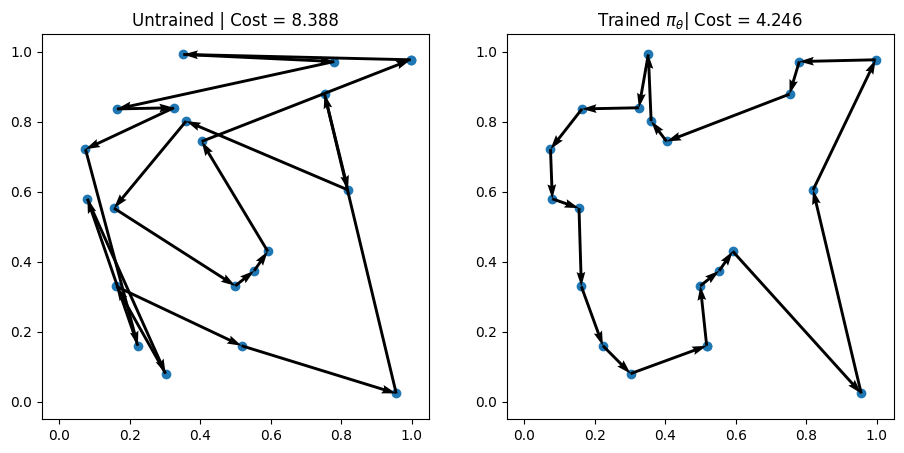

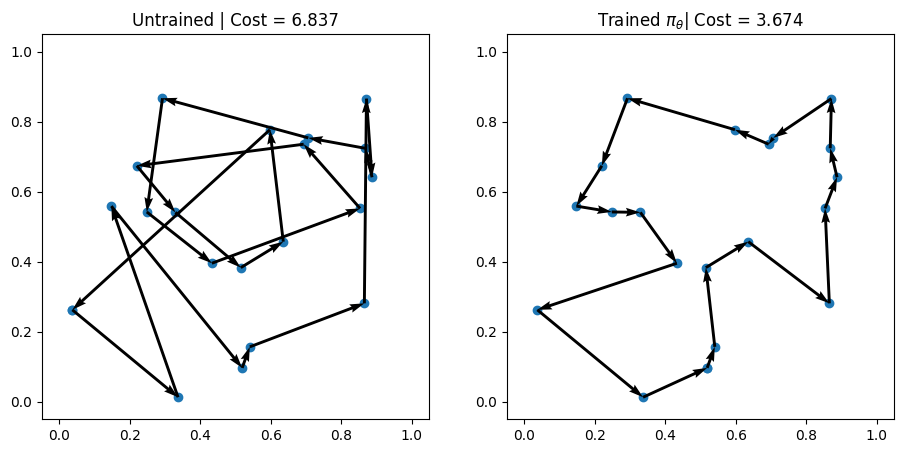

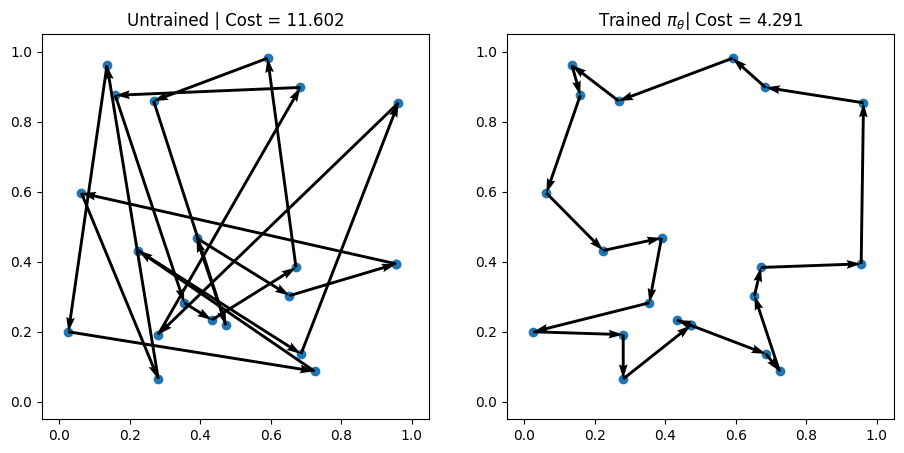

In [14]:
# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉